In [ ]:
import os
import cv2
import torch
import numpy as np
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import roc_auc_score
from torchvision import transforms, models
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# Paths
ROOT_DIR = './Input/bottle'
TRAIN_DIR = os.path.join(ROOT_DIR, 'train', 'good')
TEST_DIR = os.path.join(ROOT_DIR, 'test')
GT_DIR = os.path.join(ROOT_DIR, 'ground_truth')
RESULT_DIR = './results/bottle'
os.makedirs(RESULT_DIR, exist_ok=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

resnet = models.resnet18(pretrained=True).to(device)
resnet.eval()
features = []
def hook(module, input, output):
    features.append(output)
resnet.layer2.register_forward_hook(hook)
def extract_features(img_paths):
    feats = []
    for path in tqdm(img_paths):
        img = Image.open(path).convert('RGB')
        img = transform(img).unsqueeze(0).to(device)
        features.clear()
        _ = resnet(img)
        feat = features[0].squeeze().cpu().detach().numpy()
        feats.append(feat)
    return feats
def flatten_features(feats):
    flat = []
    for feat in feats:
        flat.append(feat.reshape(feat.shape[0], -1).T)  # [H*W, C]
    return np.concatenate(flat, axis=0)
def get_image_paths(folder):
    return [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.png')]
def get_anomaly_map(test_feat, nn_model):
    test_flat = test_feat.reshape(test_feat.shape[0], -1).T  # [H*W, C]
    dists, _ = nn_model.kneighbors(test_flat)
    anomaly_map = dists[:, 0].reshape(int(test_feat.shape[1]), int(test_feat.shape[2]))
    return anomaly_map
def save_overlay(img_path, heatmap, save_path):
    img = cv2.imread(img_path)
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_norm = cv2.normalize(heatmap_resized, None, 0, 255, cv2.NORM_MINMAX)
    heatmap_colored = cv2.applyColorMap(heatmap_norm.astype(np.uint8), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img, 0.6, heatmap_colored, 0.4, 0)
    cv2.imwrite(save_path, overlay)
def load_mask(mask_path, size=(256, 256)):
    if not os.path.exists(mask_path):
        return None
    gt = Image.open(mask_path).convert('L')
    gt = gt.resize(size)
    gt_np = np.array(gt)
    return (gt_np > 128).astype(np.uint8)

train_imgs = get_image_paths(TRAIN_DIR)
train_feats = extract_features(train_imgs)
train_flat_feats = flatten_features(train_feats)
nn_model = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(train_flat_feats)
test_types = os.listdir(TEST_DIR)
aucs = []
ious = []

for defect_type in test_types:
    test_folder = os.path.join(TEST_DIR, defect_type)
    test_imgs = get_image_paths(test_folder)
    
    for path in tqdm(test_imgs, desc=f"Testing: {defect_type}"):
        img_name = os.path.basename(path).replace('.png', '')
        gt_mask_path = os.path.join(GT_DIR, defect_type, img_name + '_mask.png')
        features.clear()
        img = Image.open(path).convert('RGB')
        img_tensor = transform(img).unsqueeze(0).to(device)
        _ = resnet(img_tensor)
        test_feat = features[0].squeeze().cpu().detach().numpy()
        anomaly_map = get_anomaly_map(test_feat, nn_model)
        # save_path = os.path.join(RESULT_DIR, f'{defect_type}_{img_name}.png')
        # save_overlay(path, anomaly_map, save_path)
        gt_mask = load_mask(gt_mask_path)
        if gt_mask is not None:
            anomaly_resized = cv2.resize(anomaly_map, (256, 256))
            anomaly_norm = (anomaly_resized - anomaly_resized.min()) / (anomaly_resized.max() - anomaly_resized.min())
            flat_pred = anomaly_norm.flatten()
            flat_gt = gt_mask.flatten()
            auc = roc_auc_score(flat_gt, flat_pred)
            aucs.append(auc)
            threshold = 0.5
            pred_mask = (anomaly_norm > threshold).astype(np.uint8)
            intersection = np.logical_and(pred_mask, gt_mask).sum()
            union = np.logical_or(pred_mask, gt_mask).sum()
            iou = intersection / union if union != 0 else 0
            ious.append(iou)

# 4. Print results
print(f"\nAverage ROC AUC: {np.mean(aucs):.4f}")
print(f"Average IoU: {np.mean(ious):.4f}")


Adding a classifier Model to detect Bottel and Carpet images

{'bottle': 0, 'capsule': 1, 'carpet': 2, 'hazelnut': 3, 'leather': 4}
Epoch 1/15 - Loss: 0.2706
Epoch 2/15 - Loss: 0.0480
Epoch 3/15 - Loss: 0.0264
Epoch 4/15 - Loss: 0.0166
Epoch 5/15 - Loss: 0.0105
Epoch 6/15 - Loss: 0.0244
Epoch 7/15 - Loss: 0.0072
Epoch 8/15 - Loss: 0.0056
Epoch 9/15 - Loss: 0.0071
Epoch 10/15 - Loss: 0.0031
Epoch 11/15 - Loss: 0.0033
Epoch 12/15 - Loss: 0.0085
Epoch 13/15 - Loss: 0.0048
Epoch 14/15 - Loss: 0.0025
Epoch 15/15 - Loss: 0.0055


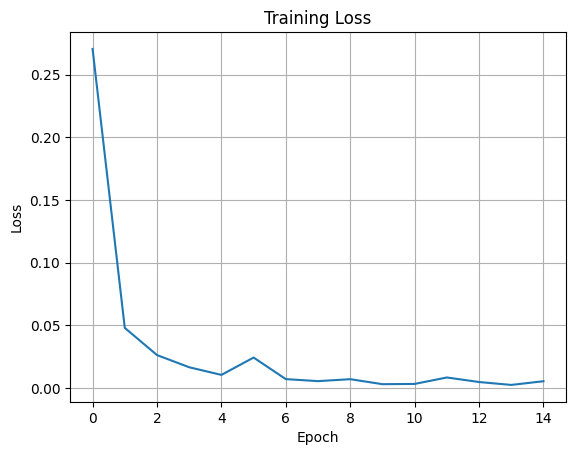

 Model saved as product_classifier.pth


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# ----------- Model -----------
class BottleCarpetClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, 3, 2, 1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, 128, 3, 2, 1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(128, 5)
        )

    def forward(self, x):
        return self.net(x)

# ----------- Data Setup -----------
DATA_DIR = "Input"
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

train_data = datasets.ImageFolder(
    root=os.path.join(DATA_DIR),
    transform=transform,
    is_valid_file=lambda x: "train/good" in x.replace("\\", "/")
)
print(train_data.class_to_idx)

label_map = {"bottle": 0,"capsule": 1,"carpet": 2,"hazelnut": 3,"leather": 4}
train_data.targets = [label_map[img_path.split(os.sep)[-4]] for img_path, _ in train_data.samples]

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)

# ----------- Training -----------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BottleCarpetClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

EPOCHS = 15
losses = []

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {avg_loss:.4f}")

# Optional: plot training loss
plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# ----------- Save Model -----------
torch.save(model.state_dict(), "Models_dump\product_classifier.pth")
print(" Model saved as product_classifier.pth")



In [5]:
import os
import cv2
import torch
import numpy as np
from PIL import Image
from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors
from torchvision import models, transforms
import joblib

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths
ROOT = "Input\leather"
TRAIN_DIR = os.path.join(ROOT, "train", "good")
SAVE_DIR = "./Models_dump"
os.makedirs(SAVE_DIR, exist_ok=True)

# Transform
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Load ResNet18
from torchvision.models import ResNet18_Weights
resnet = models.resnet18(weights=ResNet18_Weights.DEFAULT).to(device)
resnet.eval()

# Hook for layer2
features = []
resnet.layer2.register_forward_hook(lambda m, i, o: features.append(o))

def extract_features(img_paths):
    feats = []
    for path in tqdm(img_paths, desc="Extracting train features"):
        img = Image.open(path).convert('RGB')
        img_tensor = transform(img).unsqueeze(0).to(device)
        features.clear()
        _ = resnet(img_tensor)
        feat = features[0].squeeze().cpu().detach().numpy()
        feats.append(feat)
    return feats

def flatten_features(feats):
    flat = []
    for feat in feats:
        flat.append(feat.reshape(feat.shape[0], -1).T)  # [H*W, C]
    return np.concatenate(flat, axis=0)

# Load train images
train_img_paths = [os.path.join(TRAIN_DIR, f) for f in os.listdir(TRAIN_DIR) if f.endswith(".png")]

# Step 1: Extract & flatten features
train_feats = extract_features(train_img_paths)
train_flat = flatten_features(train_feats)

# Step 2: Train NearestNeighbors
nn_model = NearestNeighbors(n_neighbors=1).fit(train_flat)

# Step 3: Save artifacts
np.save(os.path.join(SAVE_DIR, "resnet_leather_train_features.npy"), train_flat)
joblib.dump(nn_model, os.path.join(SAVE_DIR, "resnet_leather_nn_model.joblib"))

print("✅ ResNet model trained and saved for leather.")


Extracting train features: 100%|██████████| 245/245 [00:11<00:00, 21.38it/s]


✅ ResNet model trained and saved for leather.


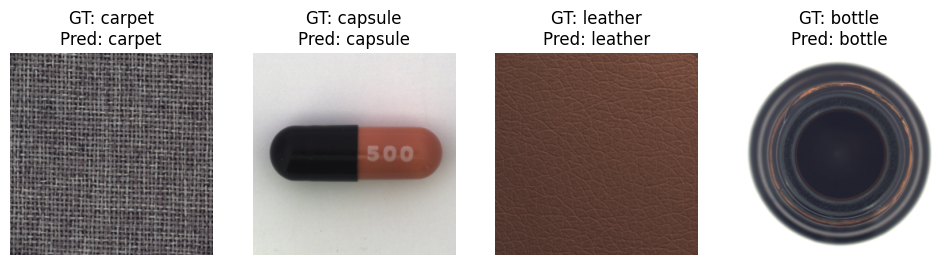

In [4]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

inv_class_map = {v: k for k, v in train_data.class_to_idx.items()}
model.eval()
with torch.no_grad():
    for images, labels in train_loader:
        outputs = model(images.to(device))
        preds = torch.argmax(outputs, dim=1).cpu()
        labels = labels.cpu()

        # Show 4 random predictions
        fig, ax = plt.subplots(1, 4, figsize=(12, 3))
        for i in range(4):
            img = images[i].permute(1, 2, 0).numpy()
            ax[i].imshow(img)
            ax[i].set_title(f"GT: {inv_class_map[labels[i].item()]}\nPred: {inv_class_map[preds[i].item()]}")
            ax[i].axis("off")
        plt.show()
        break